In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment

In [59]:
file = "Roland-D-20-Rich-Piano-C4.wav"

samplerate, data = wavfile.read(file)
data = data[:, 0]

print('Sampling Rate:',samplerate)
print('Audio Shape:', np.shape(data))

Sampling Rate: 44100
Audio Shape: (260305,)


C:\Users\kufuk\AppData\Local\Temp\ipykernel_2236\752900190.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(file)


In [51]:
duration = len(data) / samplerate
time = np.arange(0, duration, 1/samplerate)

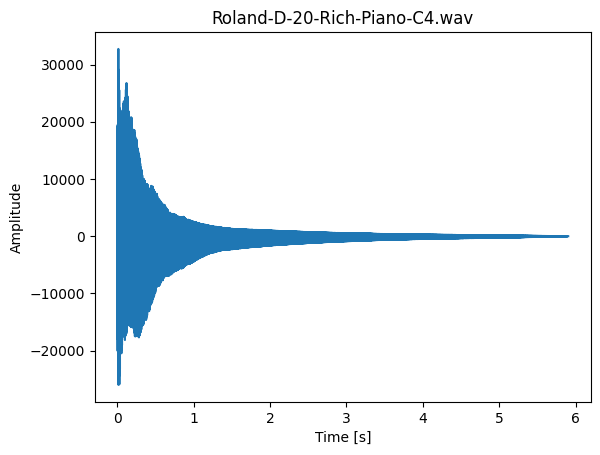

In [38]:
plt.plot(time, data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(file)
plt.show()

In [61]:
sd.play(data, samplerate)
sd.wait()

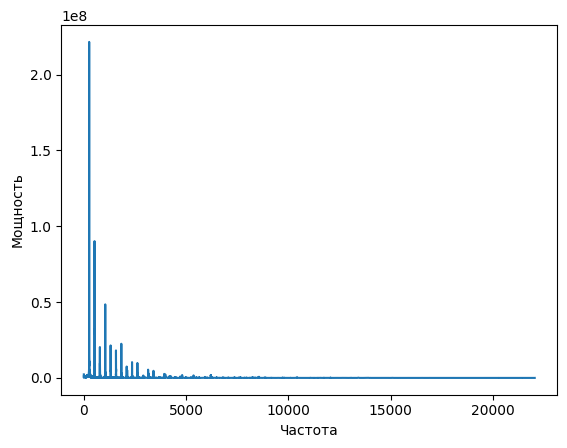

In [81]:
from scipy.fft import  rfft, rfftfreq

N = int(samplerate * duration + 0.5)

yf = rfft(data)
xf = rfftfreq(N, 1 / samplerate)

plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

In [66]:
# Фильтры

points_per_freq = len(xf) / (max(xf))

target_idx_hf = int(points_per_freq * 800)
target_idx_lf = int(points_per_freq * 400)

yf_hf = yf.copy()
yf_lf = yf.copy()
yf_bp = yf.copy()
yf_zf = yf.copy()


yf_hf[:target_idx_hf] = 0

yf_lf[target_idx_lf:] = 0

yf_bp[:target_idx_lf] = 0
yf_bp[target_idx_hf:] = 0

yf_zf[target_idx_lf:target_idx_hf] = 0

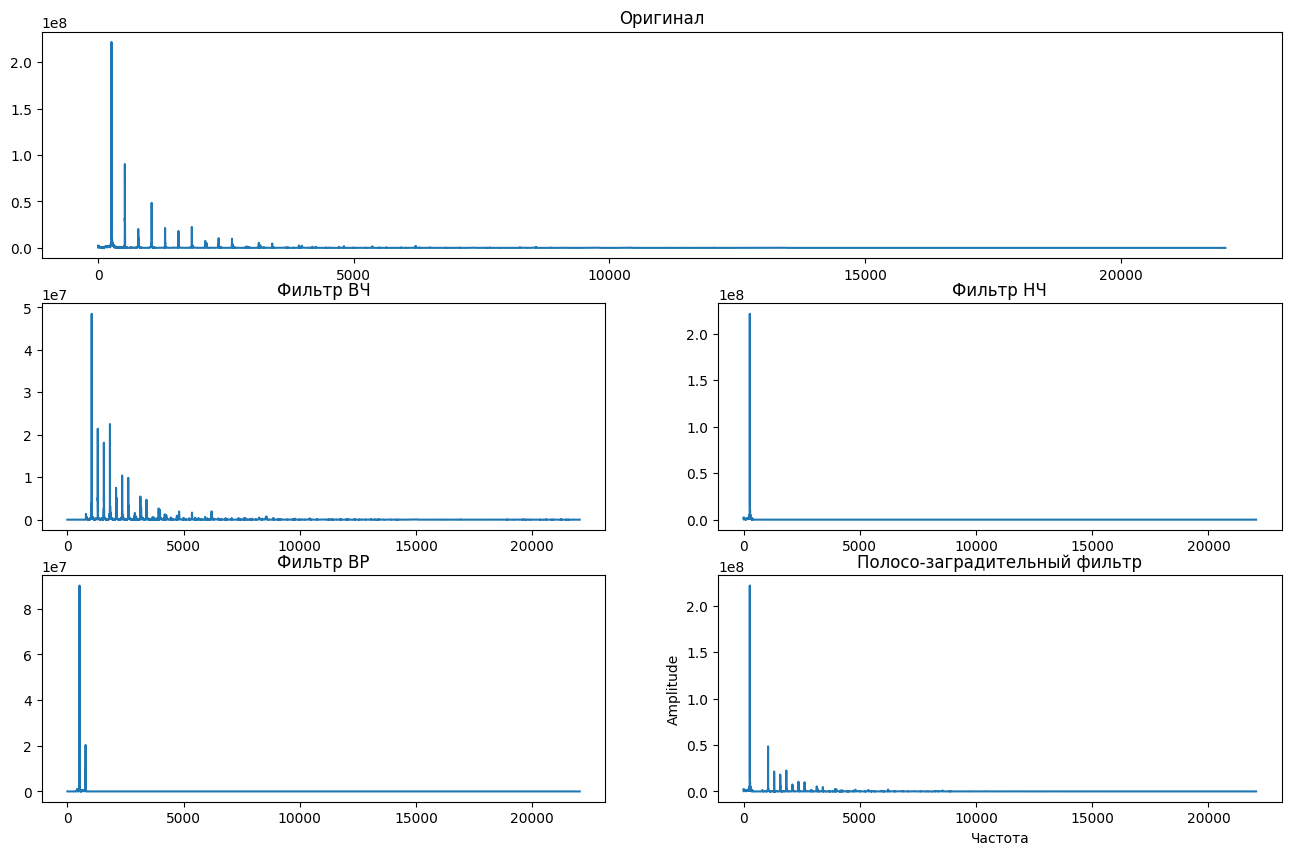

In [67]:
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(3, 1, 1)
ax1.plot(xf, np.abs(yf))
ax1.set_title("Оригинал")

ax2 = plt.subplot(3, 2, 3)
ax2.plot(xf, np.abs(yf_hf))
ax2.set_title("Фильтр ВЧ")

ax3 = plt.subplot(3, 2, 4)
ax3.plot(xf, np.abs(yf_lf))
ax3.set_title("Фильтр НЧ")

ax4 = plt.subplot(3, 2, 5)
ax4.plot(xf, np.abs(yf_bp))
ax4.set_title("Фильтр BP")

ax5 = plt.subplot(3, 2, 6)
ax5.plot(xf, np.abs(yf_zf))
ax5.set_title("Полосо-заградительный фильтр")

plt.xlabel('Частота')
plt.ylabel('Amplitude')

plt.show()  

In [82]:
from scipy.fft import irfft

new_sig_hf = irfft(yf_hf)
new_sig_lf = irfft(yf_lf)
new_sig_bp = irfft(yf_bp)
new_sig_zf = irfft(yf_zf)

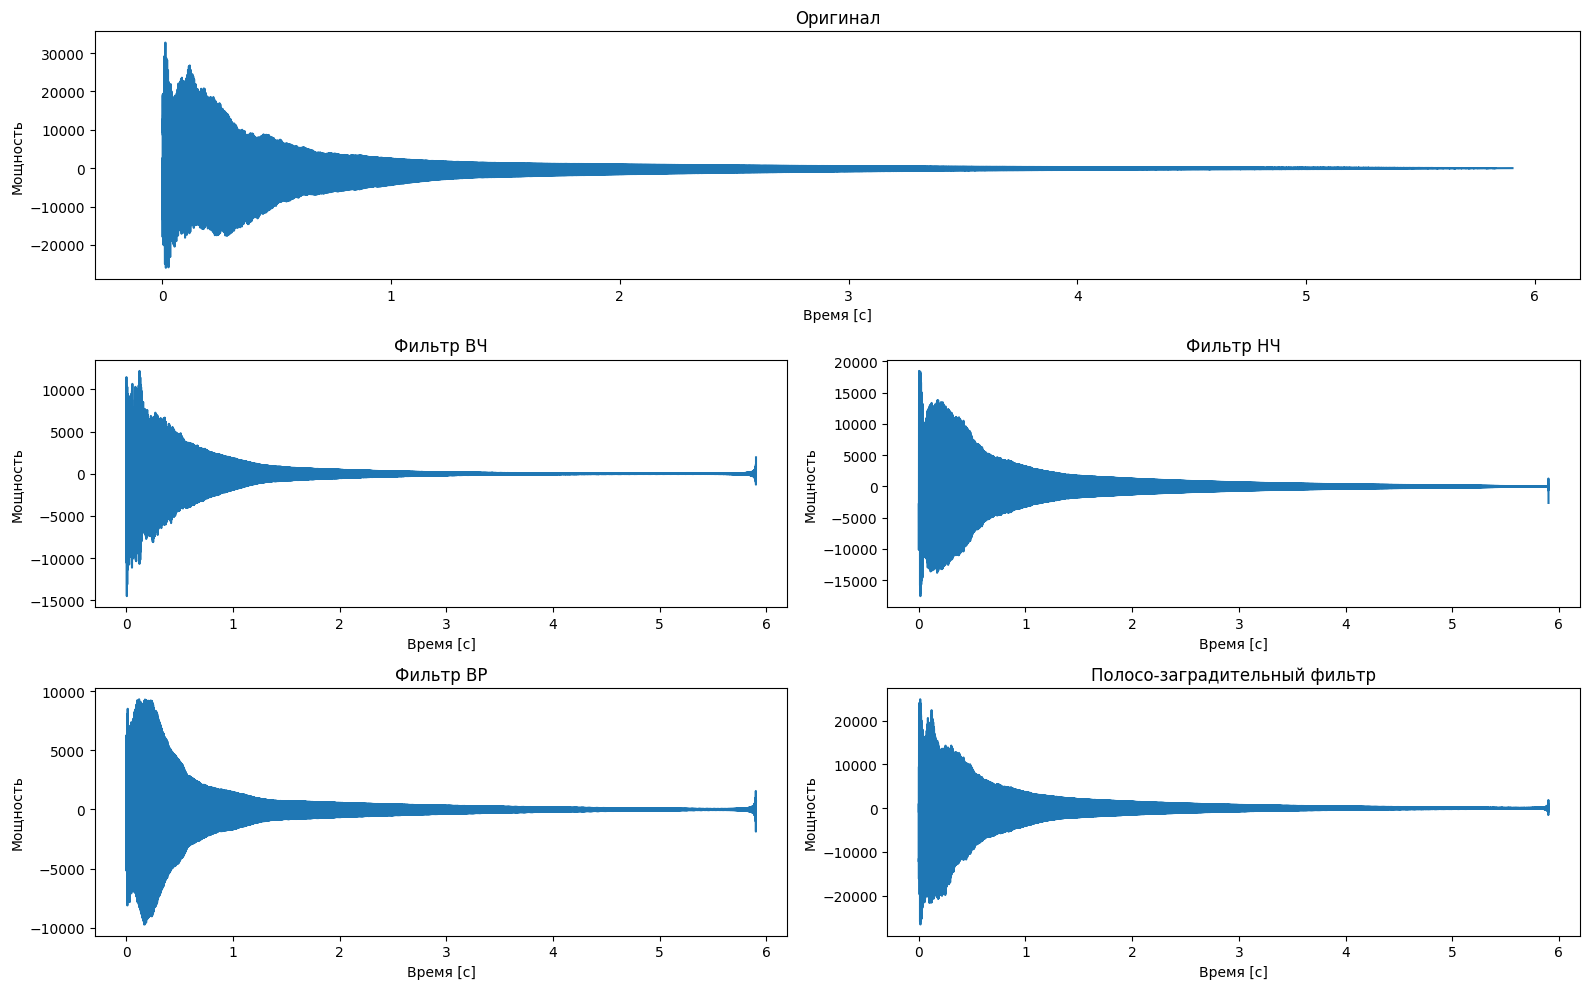

In [91]:
fig = plt.figure(figsize=(16, 10))

time_filtered = np.linspace(0, duration, len(new_sig_hf))

ax1 = plt.subplot(3, 1, 1)
ax1.plot(time, data)
ax1.set_title("Оригинал")
ax1.set_xlabel('Время [с]')
plt.ylabel('Мощность')

ax2 = plt.subplot(3, 2, 3)
ax2.plot(time_filtered, new_sig_hf)
ax2.set_title("Фильтр ВЧ")
ax2.set_xlabel('Время [с]')
plt.ylabel('Мощность')

ax3 = plt.subplot(3, 2, 4)
ax3.plot(time_filtered, new_sig_lf)
ax3.set_title("Фильтр НЧ")
ax3.set_xlabel('Время [с]')
plt.ylabel('Мощность')

ax4 = plt.subplot(3, 2, 5)
ax4.plot(time_filtered, new_sig_bp)
ax4.set_title("Фильтр BP")
ax4.set_xlabel('Время [с]')
plt.ylabel('Мощность')

ax5 = plt.subplot(3, 2, 6)
ax5.plot(time_filtered, new_sig_zf)
ax5.set_title("Полосо-заградительный фильтр")
ax5.set_xlabel('Время [с]')
plt.ylabel('Мощность')

plt.tight_layout()
plt.show()  

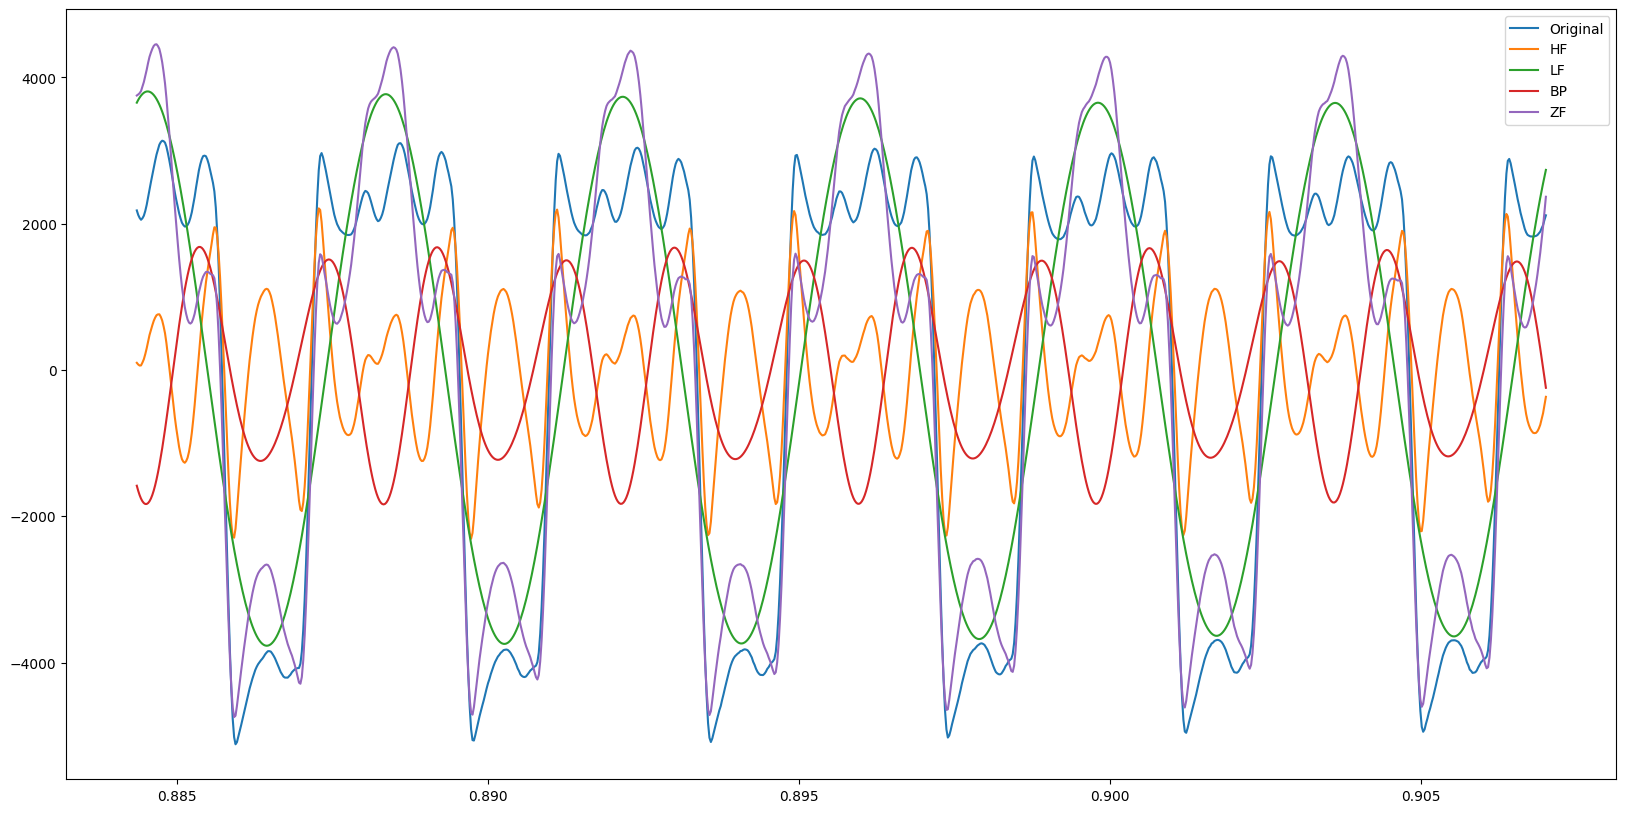

In [92]:
fig, ax = plt.subplots( figsize=(20, 10) )


original, = ax.plot(time[39000:40000], data[39000:40000], label='Original')
signal_hf, = ax.plot(time[39000:40000], new_sig_hf[39000:40000], label='HF')
signal_lf, = ax.plot(time[39000:40000], new_sig_lf[39000:40000], label='LF')
signal_bp, = ax.plot(time[39000:40000], new_sig_bp[39000:40000], label='BP')
signal_zf, = ax.plot(time[39000:40000], new_sig_zf[39000:40000], label='ZF')


ax.legend(handles=[original, signal_hf, signal_lf, signal_bp, signal_zf])

plt.show()

In [94]:
sd.play(new_sig_hf, samplerate)

In [95]:
sd.play(new_sig_bp, samplerate)

In [96]:
sd.play(new_sig_zf, samplerate)

In [97]:
sd.play(new_sig_lf, samplerate)

***

### Экспоненциальные сглаживания

In [102]:
import pandas as pd

In [98]:
def exponential_smoothing(values, alpha):
    result = [values[0], values[1]]    
    for n in range(1, len(values)):
        result.append(alpha * result[n] + (1 - alpha) * values[n-1])    
    return result

In [99]:
# Двойное
def double_exponential_smoothing(values, alpha, beta):
    result = [values[0]]
    for n in range(1, len(values)+1):
        if n == 1:
            level, trend = values[0], values[1] - values[0]
        if n >= len(values):
            value = values[-1]
        else:
            value = values[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [100]:
def plot_exponential_smoothing(series, alphas):
    with plt.style.context("_classic_test_patch"):  
        plt.figure(figsize=(15, 7))

        plt.plot(series[1], "c", label="Actual")

        for alpha in alphas:
            plt.plot(exponential_smoothing(series[1], alpha), label="Alpha {}".format(alpha))

        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

In [101]:
def plot_double_exponential_smoothing(signal_part, alphas, betas):    
    with plt.style.context('seaborn-v0_8-white'):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(signal_part, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(signal_part, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [103]:
signal_part = data[39000:40000]
time_part = time[39000:40000]
 
series = pd.Series([time[39000:40000], data[39000:40000]])

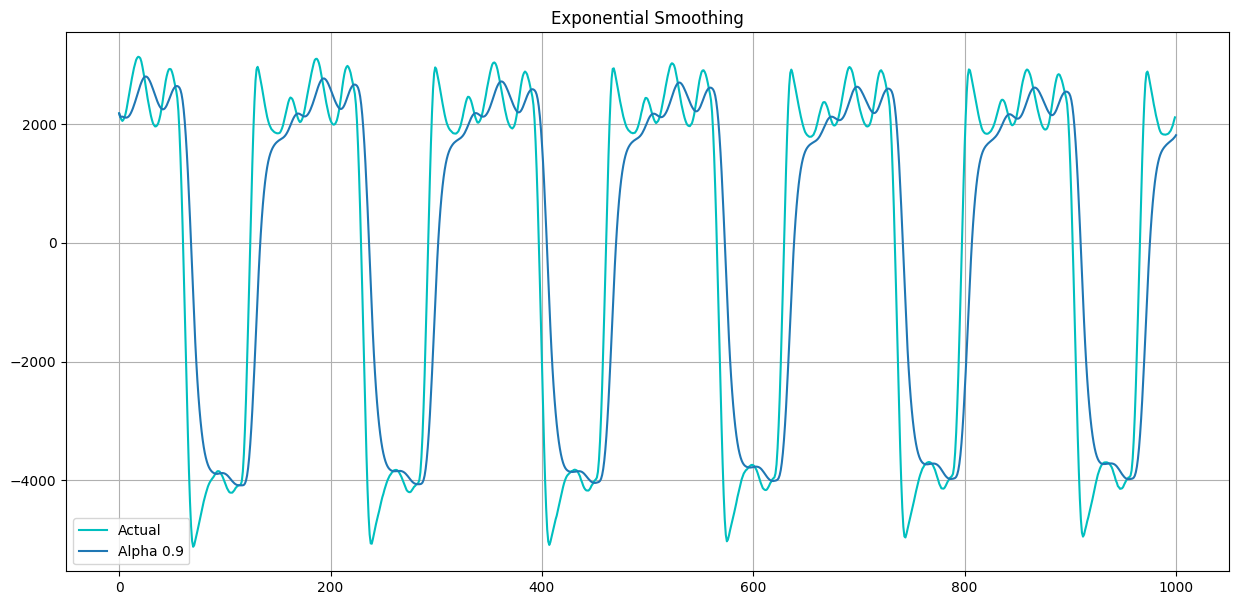

In [104]:
plot_exponential_smoothing(series, alphas=[0.9])

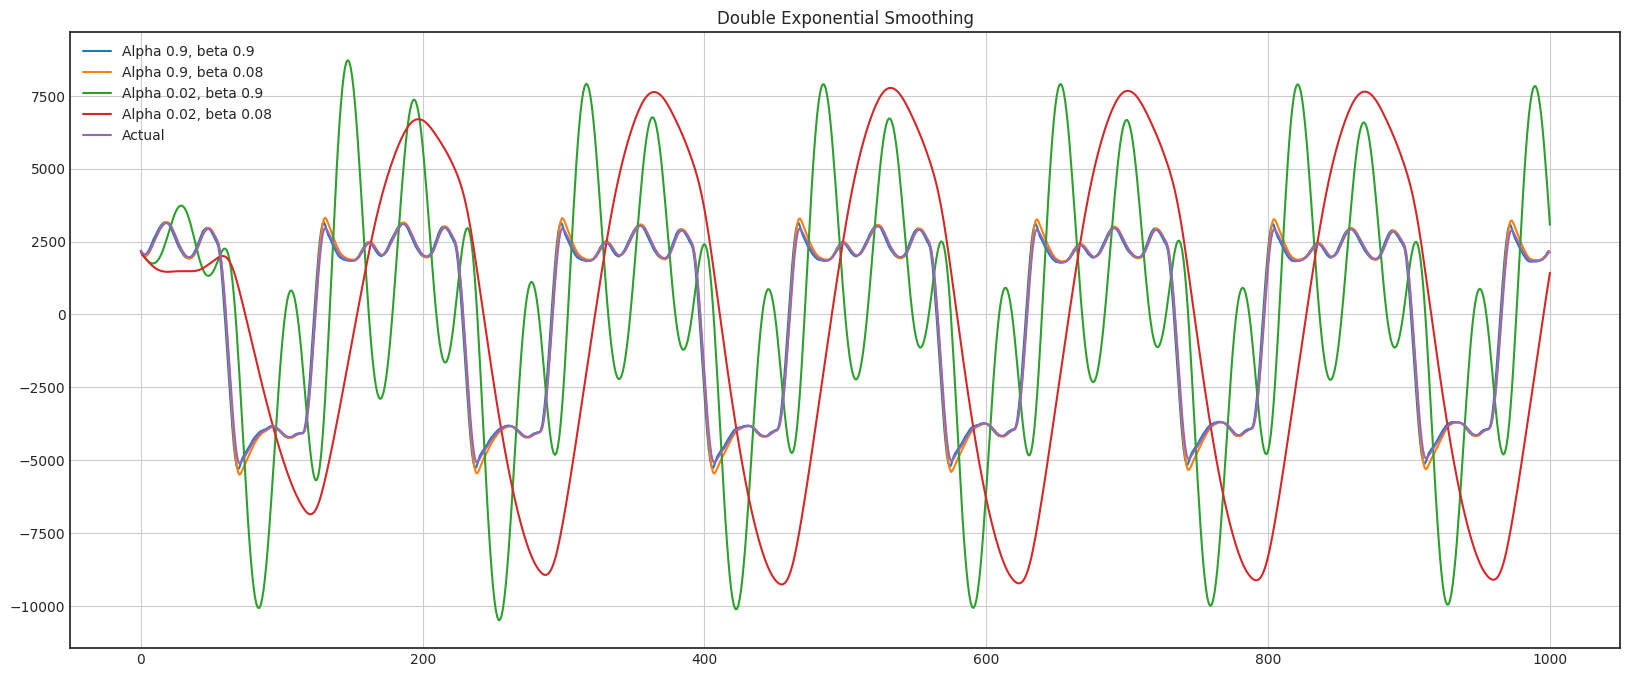

In [106]:
plot_double_exponential_smoothing(signal_part, alphas=[0.9, 0.02], betas=[0.9, 0.08])

Предсказываем

In [110]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)

    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))

    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

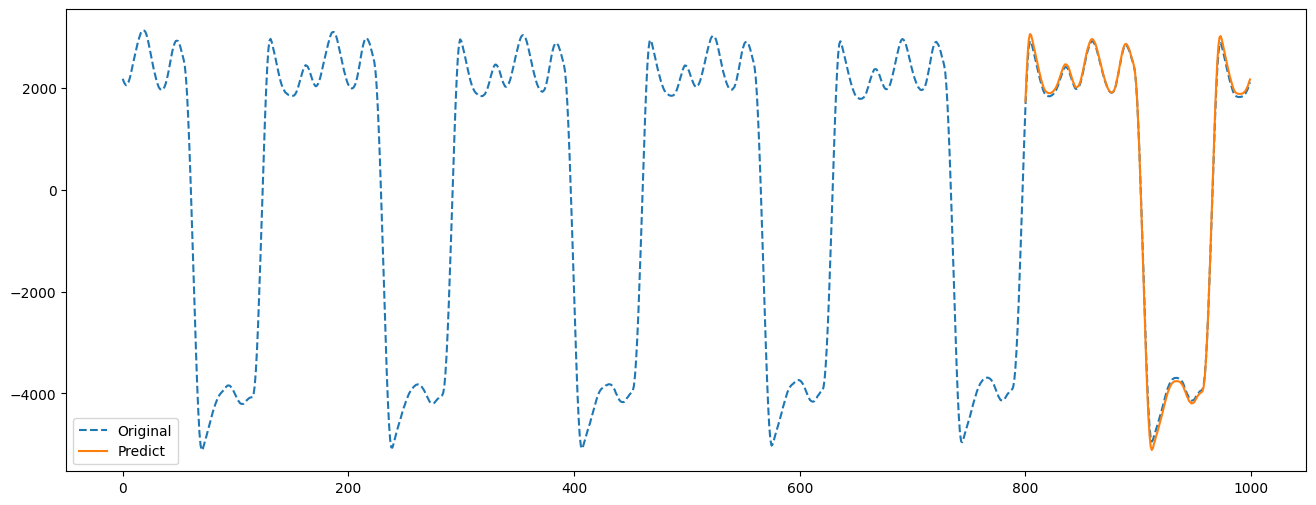

In [117]:
count = 200
ind = len(signal_part) - count
vals = triple_exponential_smoothing(signal_part, 12, 0.716, 0.029, 0.993, count)

x = range(ind + count)
x_pr = range(ind, ind + count)

plt.figure(figsize=(16, 6))

plt.plot(x[:], signal_part[:], linestyle='dashed', label='Original')
plt.plot(x_pr, vals[ind:ind + count], label='Predict')

plt.legend()
plt.show()

***

### Фильтры Чебышева (НЧ, ФЧ, полосовой, полосо-заградительный) и Баттерворта

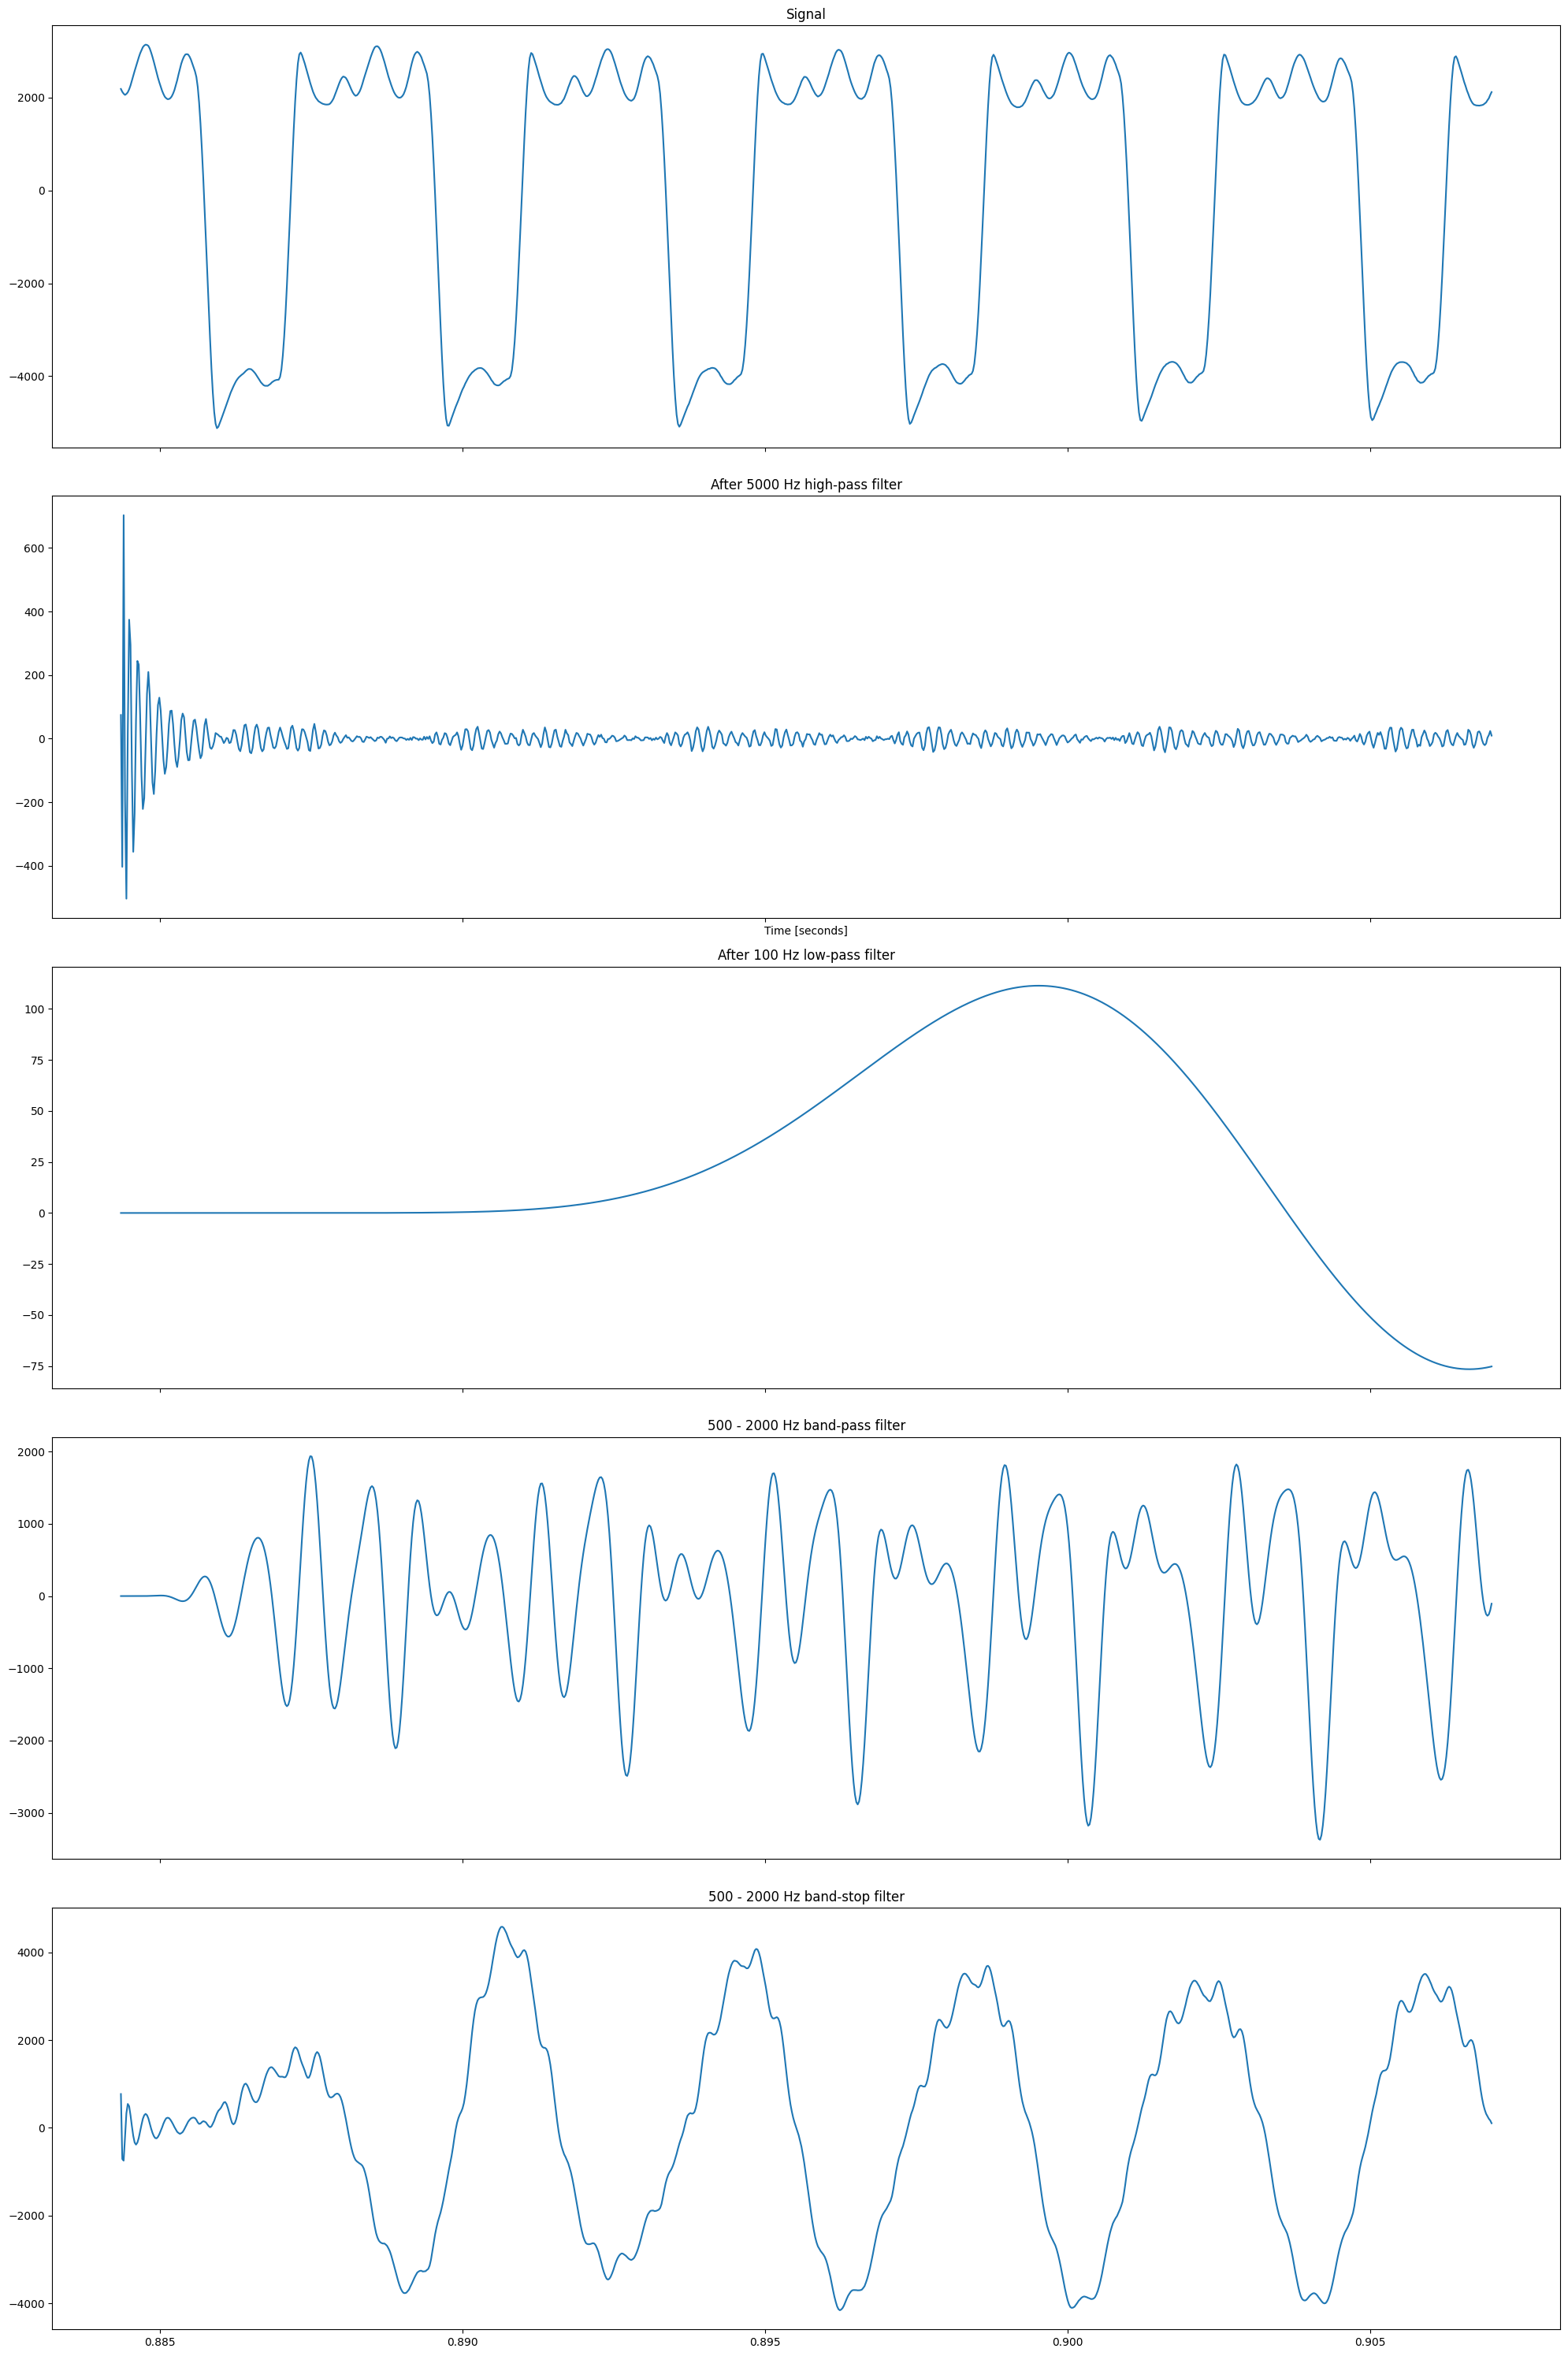

In [118]:
sos_hp = signal.cheby1(10, 1, 5000, 'hp', fs=samplerate, output='sos')
filtered_hp = signal.sosfilt(sos_hp, signal_part)

sos_lp = signal.cheby1(10, 1, 100, 'lp', fs=samplerate, output='sos')
filtered_lp = signal.sosfilt(sos_lp, signal_part)

sos_bp = signal.cheby1(10, 1, [500, 2000], 'bp', fs=samplerate, output='sos')
filtered_bp = signal.sosfilt(sos_bp, signal_part)

sos_bs = signal.cheby1(10, 1, [500, 2000], 'bs', fs=samplerate, output='sos')
filtered_bs = signal.sosfilt(sos_bs, signal_part)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(20,30))
ax1.plot(time_part, signal_part)
ax1.set_title('Signal')

ax2.plot(time_part, filtered_hp)
ax2.set_title('After 5000 Hz high-pass filter')

ax3.plot(time_part, filtered_lp)
ax3.set_title('After 100 Hz low-pass filter')

ax4.plot(time_part, filtered_bp)
ax4.set_title('500 - 2000 Hz band-pass filter')
 
ax5.plot(time_part, filtered_bs)
ax5.set_title('500 - 2000 Hz band-stop filter')

ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

In [119]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

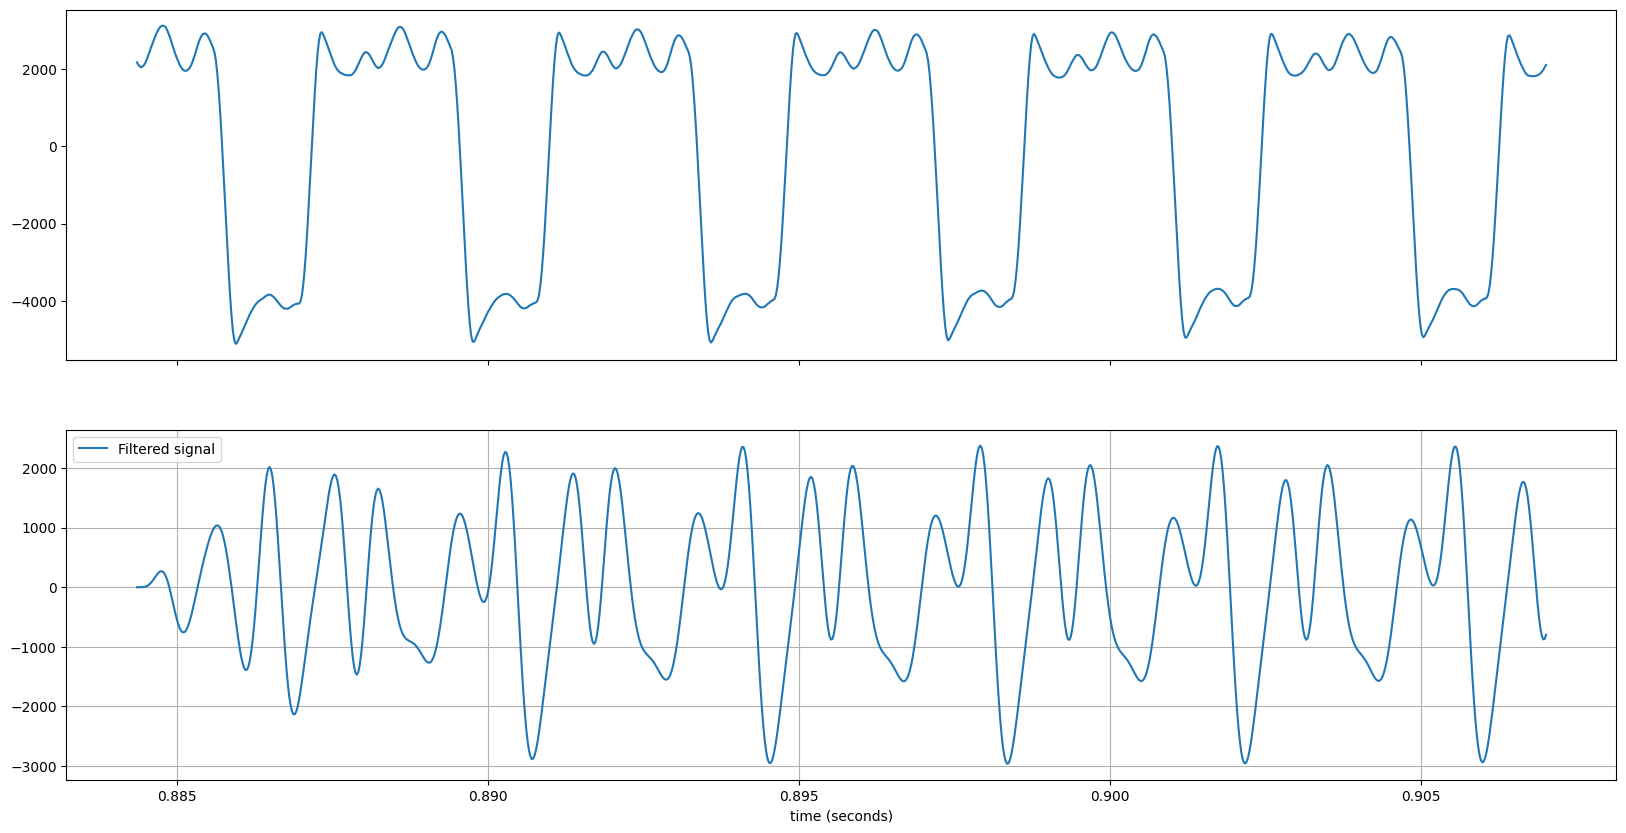

In [121]:
fs = samplerate

lowcut = 500
highcut = 2000

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))

ax1.plot(time_part, signal_part, label='Noisy signal')

y = butter_bandpass_filter(signal_part, lowcut, highcut, fs, order=6)
ax2.plot(time_part, y, label='Filtered signal')

plt.xlabel('time (seconds)')
 
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()